In [2]:
import plotly.offline as py
import plotly.figure_factory as ff
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
import plotly.graph_objs as go
from datetime import datetime

import numpy as np
from datetime import timedelta
import sqlite3

pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
# Create your connection.
cnx = sqlite3.connect("./report.db")

trades = pd.read_sql_query(sql="SELECT * FROM trades",
                           con=cnx ,
                           parse_dates=['EntryDate', 'ExitDate']).sort_values(by=['EntryDate']).dropna()
dfs={}

def getDf(ticker: str ):
    if not ticker in dfs:
        tmp=pd.read_sql_query('select * from ohlc_' + ticker,con=cnx)        
        tmp['dt'] = pd.to_datetime(tmp['dt'],unit='ms')
        dfs[ticker] = tmp
    return dfs[ticker]
    
orders = pd.read_sql_query(sql="SELECT * FROM main.orders",
                           con=cnx).dropna()


In [4]:
trades

,Ticker,OrderId0,OrderId1,EntryPriceTime,ExitPriceTime,BuySell,EntryDate,EntryPrice,ExitDate,ExitPrice,Pnl,Qty,MAE,MFE,SomeFactor
0,aflt,aflt_1,aflt_2,2013-02-28T10:00:00Z,2013-03-04T10:00:00Z,-1,2013-02-28,62.021,2013-03-03 00:10:00,60.271,28311.500,16178,0.000,0.000,0.444
35,sngs,sngs_1,sngs_2,2013-02-28T10:00:00Z,2013-03-04T10:00:00Z,-1,2013-02-28,33.609,2013-03-03 00:10:00,33.204,12127.320,29944,0.000,0.000,0.222
66,mtlr,mtlr_1,mtlr_2,2013-02-28T10:00:00Z,2013-03-04T10:00:00Z,-1,2013-02-28,271.010,2013-03-03 00:10:00,262.810,30364.600,3703,0.000,0.000,0.222
107,mgnt,mgnt_1,mgnt_2,2013-03-04T10:00:00Z,2013-03-05T10:00:00Z,-1,2013-03-02,5732.520,2013-03-05 00:10:00,5759.320,-4663.200,174,0.000,0.000,0.636
142,sberp,sberp_1,sberp_2,2013-03-04T10:00:00Z,2013-03-05T10:00:00Z,-1,2013-03-02,79.944,2013-03-05 00:10:00,79.894,625.250,12505,0.000,0.000,0.455
168,sber,sber_1,sber_2,2013-03-04T10:00:00Z,2013-03-06T10:00:00Z,-1,2013-03-03,108.246,2013-03-06 00:10:00,109.796,-14335.950,9249,0.000,0.000,0.400
190,plzl,plzl_1,plzl_2,2013-03-11T10:00:00Z,2013-03-11T10:00:00Z,-1,2013-03-08,1164.060,2013-03-11 00:10:00,1164.060,0.000,864,0.000,0.000,0.200
225,chmf,chmf_1,chmf_2,2013-03-19T10:00:00Z,2013-03-22T10:00:00Z,-1,2013-03-19,422.680,2013-03-22 00:10:00,408.180,34684.000,2392,0.000,0.000,0.667
283,hydr,hydr_1,hydr_2,2013-03-20T10:00:00Z,2013-03-25T10:00:00Z,-1,2013-03-20,0.643,2013-03-23 00:10:00,0.649,-9794.862,1554740,0.000,0.000,0.524
254,alrs,alrs_1,alrs_2,2013-03-20T10:00:00Z,2013-03-25T10:00:00Z,-1,2013-03-20,33.269,2013-03-23 00:10:00,33.731,-13676.124,29602,0.000,0.000,0.143


In [5]:
def ann(r : pd.Series):
        return [{
            'x': r['EntryDate'],  
#             'y' : r['EntryPrice'],            
            'xref': 'x', 
            'yref': 'paper',
            'showarrow': True, 
            'xanchor': 'left',
            'text': 'buy' if r.BuySell == 1 else 'sell'
            
        },
        {
            'x': r['ExitDate'],
#             'y' : r['ExitPrice'],            
            'xref': 'x', 
            'yref': 'paper',
            'showarrow': True, 
            'xanchor': 'left',
            'text': 'sell' if r.BuySell == 1 else 'buy'
            
        }]

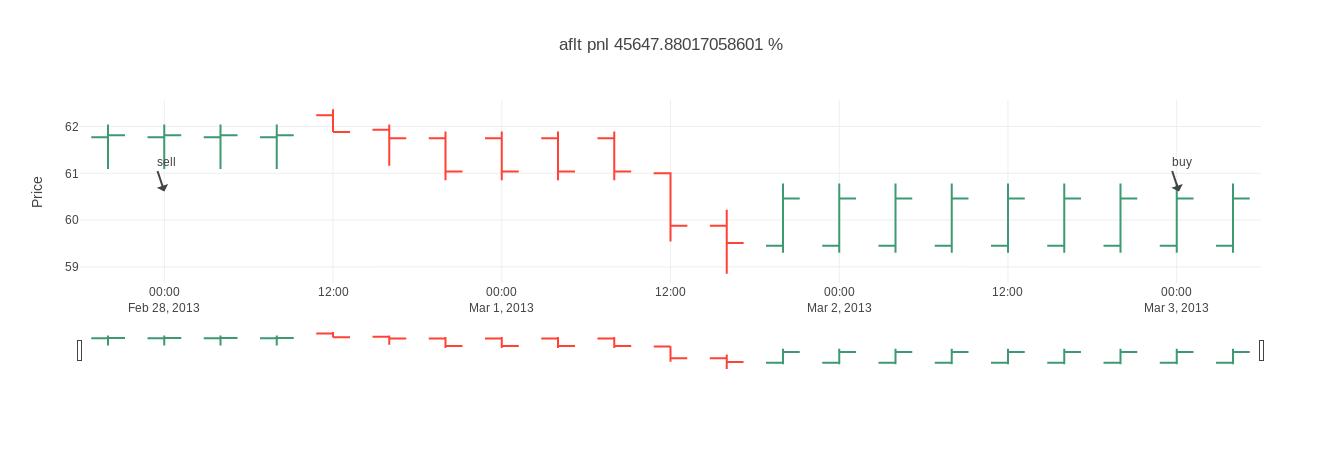

In [6]:

def plotOrders(startDt,endDt):
    ords=orders[startDt:endDt]
    ords[(ords.BuySell==-1) & (ords.OrderType=='Limit')].ix[:,'Price'].plot(color='red', linestyle='_', marker=">")
    ords[(ords.BuySell==1) & (ords.OrderType=='Limit')].ix[:,'Price'].plot(color='blue', linestyle='_', marker=">")


def showTrade(trdIdx):
    rec=trades.iloc[trdIdx, :]

    startDt = (rec['EntryDate'] - timedelta(minutes=320)).replace(second=0)
    endDt = (rec['ExitDate'] + timedelta(minutes=320)).replace(second=0)

    trds=trades[(trades.EntryDate > startDt) & (trades.EntryDate < endDt)]

#     for a,r in trds.iterrows():
#         col='red' if r['BuySell'] == -1 else 'green'
#         plt.plot([r['EntryDate'],r['ExitDate']],[r['EntryPrice'],r['ExitPrice']],color=col, marker='o')

    
    df=getDf(rec['Ticker'])
    df_l=df[(df.dt > startDt) & (df.dt < endDt)]

    
    data = [go.Ohlc(x=df_l['dt'],
                    open=df_l['o'],
                    high=df_l['h'],
                    low=df_l['l'],
                    close=df_l['c'])]
    
    layout = {
        'title': 'The Great Recession',
        'yaxis': {'title': 'Show trade'},
        'shapes': [{
            'x0': '2016-12-09', 'x1': '2016-12-09',
            'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
            'line': {'color': 'rgb(30,30,30)', 'width': 1}
        }],
        'annotations': [{
            'x': '2016-12-09',  'xref': 'x', 'yref': 'paper',
            'showarrow': True, 'xanchor': 'left',
            'text': 'Increase Period Begins'
        }]
    }
    
    layout1 = {
        'title': f'{rec.Ticker} pnl {rec.Pnl/rec.EntryPrice*100} %',
        'yaxis': {'title': 'Price'},
        'annotations': ann(rec)
    }
    
    fig = dict(data=data, layout=layout1)
    py.iplot(fig)
        

        


showTrade(0)


